# DNS Ad-Blocker Training

Train XGBoost model to block ads at DNS level using domain name features.

In [1]:
!pip install tldextract
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/content')
from enhanced_dns_features import EnhancedDNSFeatureExtractor as DNSFeatureExtractor
from tqdm.auto import tqdm

np.random.seed(42)
print("Libraries loaded")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.5 MB/s eta 0:00:00
Libraries loaded


## Load Dataset

In [2]:
df = pd.read_csv('dns_training_data.csv')

print(f"Total domains: {len(df):,}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample:")
print(df.head(10))

Total domains: 198,162

Label distribution:
label
0    99081
1    99081
Name: count, dtype: int64

Sample:
                           domain  label
0                 offerstrack.net      0
1     cheapapartmentsaroundme.com      1
2              laxtrb.112.2o7.net      1
3  freewarepalm.uk.intellitxt.com      1
4                    finicity.com      0
5                      neogov.net      0
6                     hwqloan.com      1
7                     s5idnmc.top      1
8                           dm.de      0
9                   clearrate.com      0


## Extract Features

In [3]:
extractor = DNSFeatureExtractor()

print("Extracting features from 198k domains...\n")

features_list = []
for domain in tqdm(df['domain'], desc="Extracting"):
    try:
        features = extractor.extract_features(domain)
        features_list.append(features)
    except:
        features_list.append({})

features_df = pd.DataFrame(features_list)

print(f"\nFeatures extracted: {features_df.shape[1]}")
print(f"\nSample:")
print(features_df.head())

Extracting features from 198k domains...



Extracting:   0%|          | 0/198162 [00:00<?, ?it/s]


Features extracted: 68

Sample:
   domain_length  domain_name_length  subdomain_length  subdomain_count  \
0             15                  11                 0                0   
1             27                  23                 0                0   
2             18                   3                10                2   
3             30                  10                15                2   
4             12                   8                 0                0   

   path_depth  digit_count  digit_ratio  hyphen_count  hyphen_ratio  \
0           1            0     0.000000             0           0.0   
1           1            0     0.000000             0           0.0   
2           3            5     0.277778             0           0.0   
3           3            0     0.000000             0           0.0   
4           1            0     0.000000             0           0.0   

   underscore_count  ...  tld_is_country_code  tld_is_new_gtld  \
0                 0  ..

In [4]:
X = features_df.fillna(0)
y = df['label']

print(f"Feature matrix: {X.shape}")
print(f"Labels: {y.shape}")

Feature matrix: (198162, 68)
Labels: (198162,)


## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(f"Training: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Training: 168,437 samples
Test: 29,725 samples


Stratified K-Fold + Hyperparameter Tuning using Grid search CV

In [6]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss

# Define base model with good defaults for other parameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42,
    n_jobs=1,  # Important when using n_jobs=-1 in GridSearchCV
    # Fixed parameters with reasonable defaults
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1.0,
    reg_alpha=0.1
)

param_grid = {
    'max_depth': [ 8, 16,24],           # Controls model complexity
    'learning_rate': [0.02, 0.05, 0.06],  # Controls step size
    'gamma': [0.1, 0.2, 0.3]           # Minimum loss reduction
}

# Define K-Fold strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV - Use 'neg_log_loss' directly instead of make_scorer
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='neg_log_loss',  # ✅ Built-in scorer that handles probabilities automatically
    cv=kfold,
    verbose=2,
    n_jobs=-1
)

# Run the grid search
print("Running GridSearchCV with K-Fold cross-validation...")
print(f"Total fits: {27 * 5} = 135")
grid_search.fit(X_train, y_train)

# Get best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV LogLoss:", -grid_search.best_score_)  # Negate to get positive log loss

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_logloss = log_loss(y_test, y_pred_proba)
print(f"Test LogLoss: {test_logloss:.4f}")

Running GridSearchCV with K-Fold cross-validation...
Total fits: 135 = 135
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 8}
Best CV LogLoss: 0.2981054926878891
Test LogLoss: 0.2932


## Train XGBoost Model

So, from above we can conclude, gamma =0.3 is and max_depth of 8 seems to give best perfomance from above hyperparameter. Additionally, experimenting on learning rate and number of iteration, we got the best below accuracy.

In [18]:
import xgboost as xgb

# Create XGBClassifier with the same parameters
model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=8,
    learning_rate=0.01,
    min_child_weight=3,
    eval_metric='logloss',
    random_state=42,  # 'seed' is called 'random_state' in XGBClassifier
    tree_method='hist',
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_estimators=2000,  # 'num_boost_round' is called 'n_estimators'
    early_stopping_rounds=20,
    n_jobs=-1  # Optional: use all CPU cores
)

print("Training...\n")

# Fit with evaluation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=20  # 'verbose_eval' is called 'verbose' in fit()
)

print("\nTraining complete")

# Access evaluation results
evals_result = model.evals_result()
print("\nFinal train logloss:", evals_result['validation_0']['logloss'][-1])
print("Final test logloss:", evals_result['validation_1']['logloss'][-1])

# Get predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate final test log loss
from sklearn.metrics import log_loss
final_test_logloss = log_loss(y_test, y_pred_proba)
print(f"\nTest LogLoss: {final_test_logloss:.6f}")

Training...

[0]	validation_0-logloss:0.68723	validation_1-logloss:0.68721
[20]	validation_0-logloss:0.58985	validation_1-logloss:0.58951
[40]	validation_0-logloss:0.52093	validation_1-logloss:0.52034
[60]	validation_0-logloss:0.47058	validation_1-logloss:0.46986
[80]	validation_0-logloss:0.43306	validation_1-logloss:0.43226
[100]	validation_0-logloss:0.40441	validation_1-logloss:0.40359
[120]	validation_0-logloss:0.38247	validation_1-logloss:0.38165
[140]	validation_0-logloss:0.36527	validation_1-logloss:0.36449
[160]	validation_0-logloss:0.35188	validation_1-logloss:0.35113
[180]	validation_0-logloss:0.34113	validation_1-logloss:0.34047
[200]	validation_0-logloss:0.33262	validation_1-logloss:0.33208
[220]	validation_0-logloss:0.32577	validation_1-logloss:0.32535
[240]	validation_0-logloss:0.32027	validation_1-logloss:0.32003
[260]	validation_0-logloss:0.31576	validation_1-logloss:0.31568
[280]	validation_0-logloss:0.31210	validation_1-logloss:0.31218
[300]	validation_0-logloss:0.3090

## Training Loss Curve

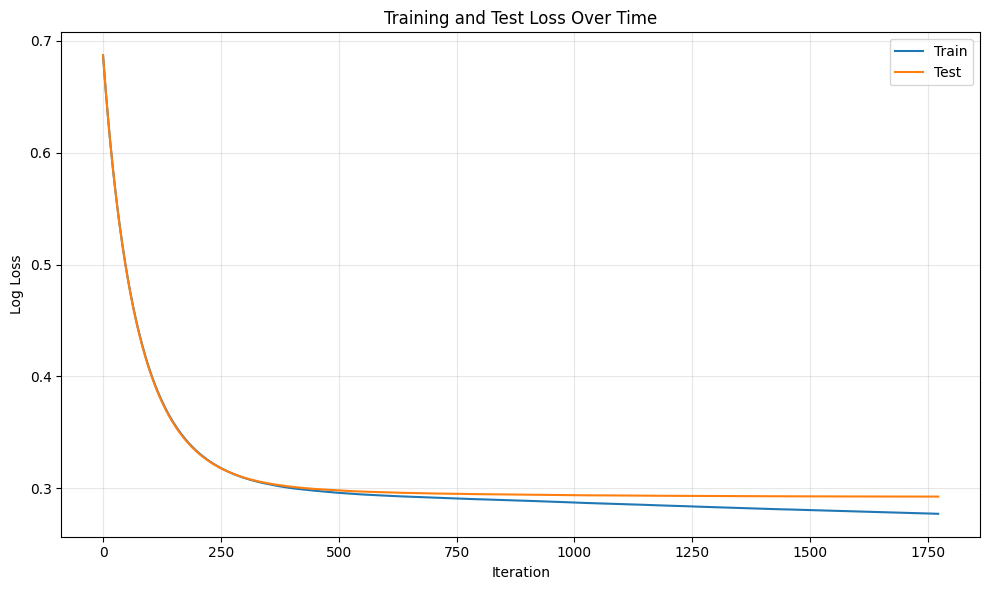

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['logloss'], label='Train')
plt.plot(evals_result['validation_1']['logloss'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()

## Evaluate Performance

In [61]:
# Get probability predictions (for class 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.985).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Ad']))

MODEL PERFORMANCE
Accuracy:  0.8106 (81.06%)
Precision: 1.0000 (100.00%)
Recall:    0.6211 (62.11%)
F1-Score:  0.7663 (76.63%)

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.73      1.00      0.84     14863
          Ad       1.00      0.62      0.77     14862

    accuracy                           0.81     29725
   macro avg       0.86      0.81      0.80     29725
weighted avg       0.86      0.81      0.80     29725



## Confusion Matrix

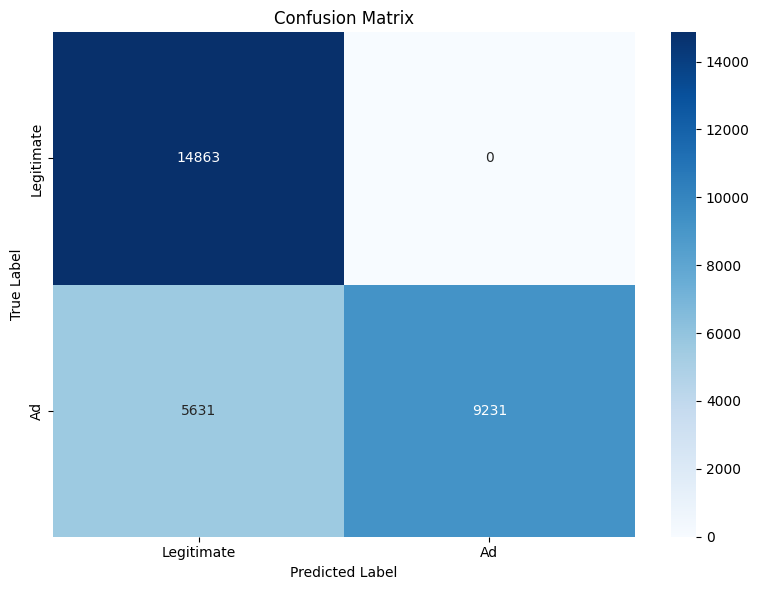

False Positive Rate: 0.0000 (0.00%)
False Negative Rate: 0.3789 (37.89%)


In [62]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Ad'],
            yticklabels=['Legitimate', 'Ad'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")

## Feature Importance

Feature importance by weight:
Counts how many times each feature is used for splitting across all trees.
Just a frequency count - doesn't consider how useful those splits were.

Top 15 Features:
                   feature  importance            feature_name
11                 entropy     13273.0                 entropy
12     domain_name_entropy     12724.0     domain_name_entropy
27       unique_char_ratio     10545.0       unique_char_ratio
9          consonant_ratio      8953.0         consonant_ratio
10             vowel_ratio      8244.0             vowel_ratio
45   vowel_consonant_ratio      6767.0   vowel_consonant_ratio
40      alphanumeric_ratio      6432.0      alphanumeric_ratio
25  max_consonant_sequence      6357.0  max_consonant_sequence
39       tld_to_full_ratio      5403.0       tld_to_full_ratio
38    domain_to_full_ratio      5356.0    domain_to_full_ratio
6              digit_ratio      3980.0             digit_ratio
0            domain_length      3949.0           domain_length
41     max_char_repetition      3604.0     max_char_repetition
19              tld_length      3511.0              tld_length
1       domain_name_length      3067.0

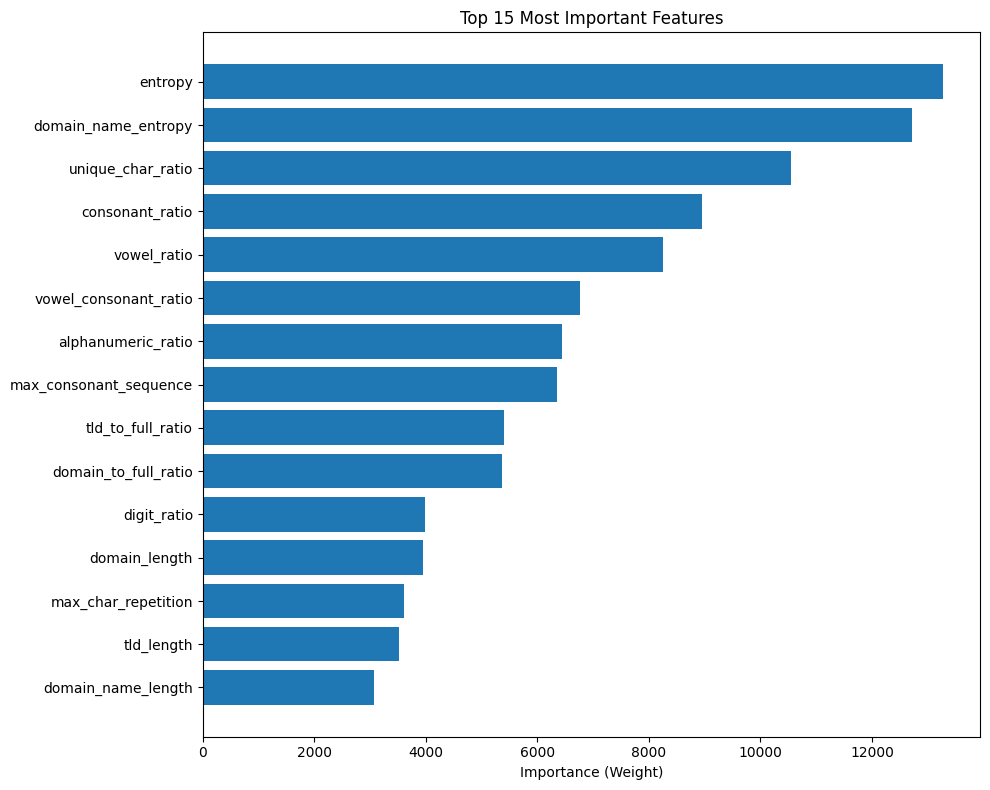

In [63]:
# Get feature importance from XGBClassifier
importance_dict = model.get_booster().get_score(importance_type='weight')

# Create DataFrame with actual feature names
feature_importance = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Map feature names (f0, f1, etc.) to actual column names
feature_names = X.columns.tolist()
feature_importance['feature_name'] = feature_importance['feature'].apply(
    lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') else x
)

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Top 15 Features:")
print(feature_importance.head(15))

# Plot
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature_name'])
plt.xlabel('Importance (Weight)')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

Feature importance by Gain

Generally, 'gain' is better because:

A feature used 100 times with tiny improvements is less valuable than a feature used 10 times with huge improvements
'gain' captures the actual predictive power of features



Top 15 Features:
                   feature  importance            feature_name
11                 entropy     13273.0                 entropy
12     domain_name_entropy     12724.0     domain_name_entropy
27       unique_char_ratio     10545.0       unique_char_ratio
9          consonant_ratio      8953.0         consonant_ratio
10             vowel_ratio      8244.0             vowel_ratio
45   vowel_consonant_ratio      6767.0   vowel_consonant_ratio
40      alphanumeric_ratio      6432.0      alphanumeric_ratio
25  max_consonant_sequence      6357.0  max_consonant_sequence
39       tld_to_full_ratio      5403.0       tld_to_full_ratio
38    domain_to_full_ratio      5356.0    domain_to_full_ratio
6              digit_ratio      3980.0             digit_ratio
0            domain_length      3949.0           domain_length
41     max_char_repetition      3604.0     max_char_repetition
19              tld_length      3511.0              tld_length
1       domain_name_length      3067.0

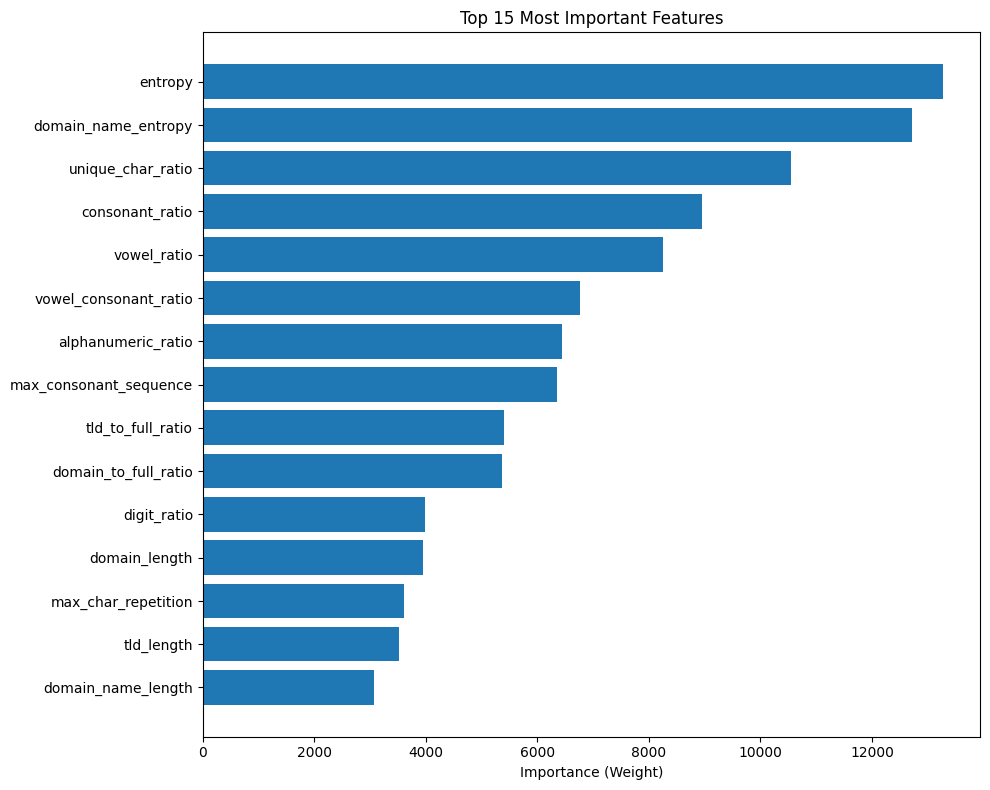

In [64]:
# Get feature importance from XGBClassifier
importance_dict = model.get_booster().get_score(importance_type='weight')

# Create DataFrame with actual feature names
feature_importance = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Map feature names (f0, f1, etc.) to actual column names
feature_names = X.columns.tolist()
feature_importance['feature_name'] = feature_importance['feature'].apply(
    lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') else x
)

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Top 15 Features:")
print(feature_importance.head(15))

# Plot
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature_name'])
plt.xlabel('Importance (Weight)')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

## Test on Real Domains

In [65]:
test_domains = [
    'googleads.g.doubleclick.net',
    'pagead2.googlesyndication.com',
    'static.ads-twitter.com',
    'an.facebook.com',
    'adservice.google.com',
    'www.google.com',
    'api.github.com',
    'www.wikipedia.org',
    'mail.yahoo.com',
    'www.reddit.com'
]

print("Testing on example domains:\n")
print("="*70)

for domain in test_domains:
    features = extractor.extract_features(domain)
    features_vec = pd.DataFrame([features])[X.columns].fillna(0)

    # Use predict_proba instead of DMatrix
    pred_proba = model.predict_proba(features_vec)[0, 1]  # Get probability of class 1 (AD)
    prediction = "AD" if pred_proba > 0.5 else "LEGITIMATE"

    print(f"{domain:45s} -> {prediction:12s} ({pred_proba:.3f})")

print("="*70)

Testing on example domains:

googleads.g.doubleclick.net                   -> AD           (1.000)
pagead2.googlesyndication.com                 -> AD           (1.000)
static.ads-twitter.com                        -> AD           (1.000)
an.facebook.com                               -> AD           (1.000)
adservice.google.com                          -> AD           (1.000)
www.google.com                                -> AD           (1.000)
api.github.com                                -> AD           (1.000)
www.wikipedia.org                             -> AD           (1.000)
mail.yahoo.com                                -> AD           (1.000)
www.reddit.com                                -> AD           (1.000)


## Save Model

In [66]:
model.save_model('dns_adblocker_model.ubj')
model.save_model('dns_adblocker_model.json')

import json
with open('feature_names.json', 'w') as f:
    json.dump(X.columns.tolist(), f, indent=2)

import os
ubj_size = os.path.getsize('dns_adblocker_model.ubj') / 1024
json_size = os.path.getsize('dns_adblocker_model.json') / 1024

print("Model saved:")
print(f"  dns_adblocker_model.ubj ({ubj_size:.1f} KB)")
print(f"  dns_adblocker_model.json ({json_size:.1f} KB)")
print(f"  feature_names.json")
print(f"\nModel ready for deployment")

Model saved:
  dns_adblocker_model.ubj (10179.1 KB)
  dns_adblocker_model.json (16376.4 KB)
  feature_names.json

Model ready for deployment
